---
title: "Stock Market Trend Forecast"
subtitle: "Using Technical Analysis and Machine Learning"
author: "Hoang Son Lai"
categories: [Stock, Technical Analysis, Machine Learning]
format: 
 html:
  toc: true
  css: styles.css
  embed-resources: true
  code-fold: true
---

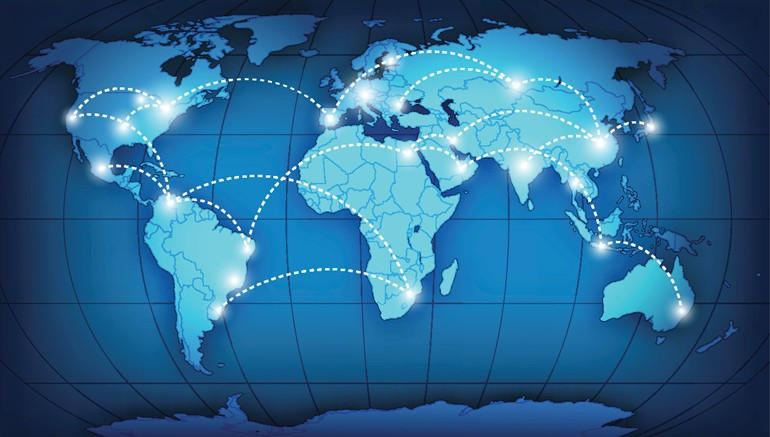

## Part 1. Data Description

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"
pio.templates.default = "plotly_white"
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output
# To convert to html use quarto render ml_report.ipynb

# Load Data
try:
    df = pd.read_csv('report_data/stock_prices.csv')
    df['date'] = pd.to_datetime(df['date'])
    # Sort by Ticker and Date for accurate calculation
    df = df.sort_values(['ticker', 'date'])
except FileNotFoundError:
    print("Error: File 'stock_prices.csv' not found.")

This dataset provides a robust historical record of market performance for 21 unique tickers, spanning from December 7, 2020, to February 3, 2026.

Notably, the data exhibits exceptional quality and balance: every ticker contains exactly 1,295 trading days, ensuring a uniform time-series structure. With 0% missing values and no duplicate entries found, this clean dataset serves as a reliable foundation for technical analysis and algorithmic backtesting.

In [2]:
def describe_market_data(df):
# 1. Basic Structure
    print(f"▶ Total Rows:       {df.shape[0]:,}")
    print(f"▶ Total Columns:    {df.shape[1]}")
    print(f"▶ Column Name: {df.columns}")
    
# 2. Temporal Analysis (Date Range)
    # Ensure date column is datetime
    if 'date' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['date']):
            try:
                df['date'] = pd.to_datetime(df['date'])
                print("✓ 'date' column converted to datetime format.")
            except:
                print("⚠ Warning: Could not convert 'date' column.")
        
        start_date = df['date'].min().strftime('%Y-%m-%d')
        end_date = df['date'].max().strftime('%Y-%m-%d')
        duration = (df['date'].max() - df['date'].min()).days
        
        print("\nTIME PERIOD:")
        print(f"▶ Start Date:       {start_date}")
        print(f"▶ End Date:         {end_date}")
        print(f"▶ Duration:         {duration} days")
    else:
        print("\n⚠ 'date' column not found!")

    # 3. Ticker Analysis
    if 'ticker' in df.columns:
        unique_tickers = df['ticker'].nunique()
        tickers_list = df['ticker'].unique()
        
        print("\nTICKER STATISTICS:")
        print(f"▶ Unique Tickers:   {unique_tickers}")
        
        # Check for data balance (Top 5 and Bottom 5 tickers by row count)
        ticker_counts = df['ticker'].value_counts()
        print(f"▶ Most Data:        {ticker_counts.index[0]} ({ticker_counts.iloc[0]} rows)")
        print(f"▶ Least Data:       {ticker_counts.index[-1]} ({ticker_counts.iloc[-1]} rows)")
        
        # Example list
        if unique_tickers > 10:
            print(f"▶ Examples:         {', '.join(tickers_list[:5])} ... {', '.join(tickers_list[-5:])}")
        else:
            print(f"▶ List:             {', '.join(tickers_list)}")
    else:
        print("\n⚠ 'ticker' column not found!")

    # 4. Data Quality Check
    print("\nDATA QUALITY CHECK:")
    
    # Missing Values
    missing_data = df.isnull().sum()
    total_cells = np.prod(df.shape)
    total_missing = missing_data.sum()
    
    print(f"▶ Missing Values:   {total_missing:,} cells ({total_missing/total_cells:.2%})")
    
    if total_missing > 0:
        print("  - Columns with most missing values:")
        print(missing_data[missing_data > 0].sort_values(ascending=False).head(5).to_string(header=False))

    # Duplicates Check (assuming Ticker + Date should be unique)
    if 'ticker' in df.columns and 'date' in df.columns:
        duplicates = df.duplicated(subset=['ticker', 'date']).sum()
        if duplicates > 0:
            print(f"⚠ CRITICAL: Found {duplicates} duplicate rows based on Ticker + Date!")
        else:
            print("✓ Integrity Check:  No duplicate (Ticker + Date) pairs found.")
        
describe_market_data(df)

▶ Total Rows:       27,195
▶ Total Columns:    9
▶ Column Name: Index(['id', 'ticker', 'date', 'open', 'high', 'low', 'close', 'adj_close',
       'volume'],
      dtype='str')

TIME PERIOD:
▶ Start Date:       2020-12-07
▶ End Date:         2026-02-03
▶ Duration:         1884 days

TICKER STATISTICS:
▶ Unique Tickers:   21
▶ Most Data:        AAPL (1295 rows)
▶ Least Data:       WMT (1295 rows)
▶ Examples:         AAPL, ADBE, AMZN, BAC, DIS ... PYPL, TSLA, UNH, V, WMT

DATA QUALITY CHECK:
▶ Missing Values:   0 cells (0.00%)
✓ Integrity Check:  No duplicate (Ticker + Date) pairs found.


## Part 2. Technical Analysis

This section provides a comprehensive technical analysis of stock prices using multiple indicators. For each stock, I calculate key metrics: 

1. Trend Indicators:

- MA20/MA50: 20-day and 50-day Simple Moving Averages compare current price to short/medium-term trends (Price > MA = bullish +1, Price < MA = bearish -1)

- EMA20: 20-day Exponential Moving Average gives more weight to recent prices for short-term trend direction

2. Momentum Indicators:

- RSI (14-day): Measures overbought (>70 = -1) vs. oversold (<30 = +1) conditions, with 30-70 being neutral

- MACD: Signal line crossover indicator (MACD > 0 = +1 bullish momentum, MACD < 0 = -1 bearish momentum)

3. Volatility & Volume Indicators:

- Bollinger Bands: Price above upper band = overbought (-1), below lower band = oversold (+1), within bands = neutral (0)

- MFI (Money Flow Index): Volume-weighted RSI (>80 = -1 overbought, <20 = +1 oversold, 20-80 = neutral)

Each indicator is scored (+1 for bullish, -1 for bearish, 0 for neutral), with a final aggregate signal determining the overall market outlook (Positive, Negative, or Neutral).

In [3]:
# 1. Define a function to calculate indicators for a single dataframe
def calculate_indicators(data):
    # Ensure data is sorted by date
    data = data.sort_values('date').reset_index(drop=True)
    
    # Trend Indicators
    data.ta.sma(length=20, append=True)  # Simple Moving Average (20)
    data.ta.sma(length=50, append=True) # Simple Moving Average (50)
    data.ta.ema(length=20, append=True)  # Exponential Moving Average (20)
    
    # Momentum Indicators
    data.ta.rsi(length=14, append=True)  # Relative Strength Index (14)
    
    # Volatility Indicators - Bollinger Bands
    # Using bbands with standard parameters
    bbands = data.ta.bbands(length=20, std=2, append=True)
    
    # Trend Following (MACD)
    data.ta.macd(fast=12, slow=26, signal=9, append=True)
    
    # Money Flow Index (MFI)
    data.ta.mfi(length=14, append=True)
    
    # Volume
    data['Volume'] = data['volume']
    
    return data

# 2. Apply calculation to all tickers
# Create a list to store processed dataframes
processed_frames = []

# Get list of unique tickers
tickers = df['ticker'].unique()

for ticker in tickers:
    # Filter data for specific ticker
    ticker_df = df[df['ticker'] == ticker].copy()
    
    # Calculate indicators (need at least 200 days for MA200)
    if len(ticker_df) > 200:
        try:
            ticker_df = calculate_indicators(ticker_df)
            processed_frames.append(ticker_df)
            print(f"✓ Processed {ticker}: {len(ticker_df)} rows, columns: {len(ticker_df.columns)}")
        except Exception as e:
            print(f"✗ Error processing {ticker}: {e}")
    else:
        print(f"✗ Skipped {ticker}: Not enough data ({len(ticker_df)} rows, need at least 200)")

# Combine back into a single main DataFrame
if processed_frames:
    df_ta = pd.concat(processed_frames, ignore_index=True)
    print(f"\nCombined DataFrame shape: {df_ta.shape}")
    print(f"Available columns: {df_ta.columns.tolist()}")
else:
    print("No data was processed!")
    df_ta = pd.DataFrame()

# 3. Check column names and find Bollinger Bands columns
if not df_ta.empty:
    print("\nSearching for Bollinger Bands columns...")
    bollinger_cols = [col for col in df_ta.columns if 'BB' in col or 'bb' in col]
    print(f"Bollinger Bands columns found: {bollinger_cols}")
    
    # Find the actual column names for BB upper and lower
    bb_upper = None
    bb_lower = None
    bb_middle = None
    
    for col in bollinger_cols:
        col_lower = col.lower()
        if 'bbu' in col_lower or 'upper' in col_lower:
            bb_upper = col
        elif 'bbl' in col_lower or 'lower' in col_lower:
            bb_lower = col
        elif 'bbm' in col_lower or 'middle' in col_lower:
            bb_middle = col
    
    print(f"Upper BB column: {bb_upper}")
    print(f"Lower BB column: {bb_lower}")
    print(f"Middle BB column: {bb_middle}")

# 4. Calculate scores for each indicator with safe column access
def calculate_scores(row):
    scores = {}
    
    # Helper function to safely get values
    def get_value(col_name, default=np.nan):
        if col_name in row and pd.notna(row[col_name]):
            return row[col_name]
        return default
    
    # MA20 vs Close
    ma20 = get_value('SMA_20')
    if pd.notna(ma20):
        if row['close'] > ma20:
            scores['MA20'] = 1
        elif row['close'] < ma20:
            scores['MA20'] = -1
        else:
            scores['MA20'] = 0
    
    # MA50 vs Close
    ma50 = get_value('SMA_50')
    if pd.notna(ma50):
        if row['close'] > ma50:
            scores['MA50'] = 1
        elif row['close'] < ma50:
            scores['MA50'] = -1
        else:
            scores['MA50'] = 0
    
    # EMA20 vs Close
    ema20 = get_value('EMA_20')
    if pd.notna(ema20):
        if row['close'] > ema20:
            scores['EMA'] = 1
        elif row['close'] < ema20:
            scores['EMA'] = -1
        else:
            scores['EMA'] = 0
    
    # MACD
    macd = get_value('MACD_12_26_9') or get_value('MACD')
    if pd.notna(macd):
        if macd > 0:
            scores['MACD'] = 1
        elif macd < 0:
            scores['MACD'] = -1
        else:
            scores['MACD'] = 0
    
    # RSI
    rsi = get_value('RSI_14')
    if pd.notna(rsi):
        if rsi > 70:
            scores['RSI'] = -1  # Overbought
        elif rsi < 30:
            scores['RSI'] = 1   # Oversold
        else:
            scores['RSI'] = 0   # Neutral
    
    # Bollinger Bands
    if bb_upper and bb_lower:
        bb_upper_val = get_value(bb_upper)
        bb_lower_val = get_value(bb_lower)
        
        if pd.notna(bb_upper_val) and pd.notna(bb_lower_val):
            if row['close'] > bb_upper_val:
                scores['BB'] = -1   # Overbought (above upper band)
            elif row['close'] < bb_lower_val:
                scores['BB'] = 1    # Oversold (below lower band)
            else:
                scores['BB'] = 0    # Within bands
    
    # MFI (Money Flow Index)
    mfi = get_value('MFI_14')
    if pd.notna(mfi):
        if mfi > 80:
            scores['MFI'] = -1  # Overbought
        elif mfi < 20:
            scores['MFI'] = 1   # Oversold
        else:
            scores['MFI'] = 0   # Neutral
    
    # Calculate total score
    total_score = sum(scores.values()) if scores else 0
    
    # Determine signal
    if total_score > 0:
        signal = 'Positive'
    elif total_score < 0:
        signal = 'Negative'
    else:
        signal = 'Neutral'
    
    # Add scores and signal to row
    row['MA20_Score'] = scores.get('MA20', 0)
    row['MA50_Score'] = scores.get('MA50', 0)
    row['EMA_Score'] = scores.get('EMA', 0)
    row['MACD_Score'] = scores.get('MACD', 0)
    row['RSI_Score'] = scores.get('RSI', 0)
    row['BB_Score'] = scores.get('BB', 0)
    row['MFI_Score'] = scores.get('MFI', 0)
    row['Total_Score'] = total_score
    row['Signal'] = signal
    
    return row

# Apply scoring function if we have data
if not df_ta.empty:
    print("\nCalculating scores for each row...")
    df_ta = df_ta.apply(calculate_scores, axis=1)
    
    # 5. Create a summary report table (latest data for each ticker)
    # Get the latest date for each ticker
    latest_dates = df_ta.groupby('ticker')['date'].max()
    
    # Create summary dataframe
    summary_rows = []
    for ticker, latest_date in latest_dates.items():
        ticker_data = df_ta[(df_ta['ticker'] == ticker) & (df_ta['date'] == latest_date)]
        if not ticker_data.empty:
            latest_row = ticker_data.iloc[0]
            
            summary_rows.append({
                'Ticker': ticker,
                'Close Price': latest_row['close'],
                'Volume': latest_row['volume'],
                'MA20': latest_row.get('SMA_20', np.nan),
                'MA50': latest_row.get('SMA_50', np.nan),
                'EMA20': latest_row.get('EMA_20', np.nan),
                'MACD': latest_row.get('MACD_12_26_9', np.nan),
                'RSI': latest_row.get('RSI_14', np.nan),
                'BB Upper': latest_row.get(bb_upper, np.nan) if bb_upper else np.nan,
                'BB Lower': latest_row.get(bb_lower, np.nan) if bb_lower else np.nan,
                'MFI': latest_row.get('MFI_14', np.nan),
                'MA20 Score': latest_row['MA20_Score'],
                'MA50 Score': latest_row['MA50_Score'],
                'EMA Score': latest_row['EMA_Score'],
                'MACD Score': latest_row['MACD_Score'],
                'RSI Score': latest_row['RSI_Score'],
                'BB Score': latest_row['BB_Score'],
                'MFI Score': latest_row['MFI_Score'],
                'Total Score': latest_row['Total_Score'],
                'Signal': latest_row['Signal']
            })
    
    # Create summary dataframe
    summary_df = pd.DataFrame(summary_rows)
    
    # 6. Display the summary table with styling
    def style_scores(val):
        if isinstance(val, (int, float)):
            if val > 0:
                return 'color: green; font-weight: bold;'
            elif val < 0:
                return 'color: red; font-weight: bold;'
            else:
                return 'color: black;'
        return ''
    
    def style_signal(val):
        if val == 'Positive':
            return 'background-color: #d4edda; color: #155724; font-weight: bold;'
        elif val == 'Negative':
            return 'background-color: #f8d7da; color: #721c24; font-weight: bold;'
        else:
            return 'background-color: #fff3cd; color: #856404; font-weight: bold;'
    
    # Apply styling - using map() instead of applymap() for newer pandas versions
    score_columns = ['MA20 Score', 'MA50 Score', 'EMA Score', 'MACD Score', 
                    'RSI Score', 'BB Score', 'MFI Score', 'Total Score']
    
    # Filter columns that actually exist in the dataframe
    existing_score_cols = [col for col in score_columns if col in summary_df.columns]
    
    # Create styler object
    styler = summary_df.style
    
    # Apply formatting
    styler = styler.format({
        'Close Price': '{:.2f}',
        'MA20': '{:.2f}',
        'MA50': '{:.2f}',
        'EMA20': '{:.2f}',
        'MACD': '{:.4f}',
        'RSI': '{:.1f}',
        'BB Upper': '{:.2f}',
        'BB Lower': '{:.2f}',
        'MFI': '{:.1f}',
        'Volume': '{:,.0f}'
    })
    
    # Apply styling to score columns (use map for newer pandas)
    if existing_score_cols:
        styler = styler.map(style_scores, subset=existing_score_cols)
    
    # Apply styling to signal column
    if 'Signal' in summary_df.columns:
        styler = styler.map(style_signal, subset=['Signal'])
    
    # Set properties and table styles
    styler = styler.set_properties(**{
        'text-align': 'center',
        'border': '1px solid #ddd',
        'padding': '5px'
    })
    
    styler = styler.set_caption("Technical Analysis Summary - Latest Signals")



✓ Processed AAPL: 1295 rows, columns: 23
✓ Processed ADBE: 1295 rows, columns: 23
✓ Processed AMZN: 1295 rows, columns: 23
✓ Processed BAC: 1295 rows, columns: 23
✓ Processed DIS: 1295 rows, columns: 23
✓ Processed GOOGL: 1295 rows, columns: 23
✓ Processed HD: 1295 rows, columns: 23
✓ Processed JNJ: 1295 rows, columns: 23
✓ Processed JPM: 1295 rows, columns: 23
✓ Processed KO: 1295 rows, columns: 23
✓ Processed MA: 1295 rows, columns: 23
✓ Processed META: 1295 rows, columns: 23
✓ Processed MSFT: 1295 rows, columns: 23
✓ Processed NFLX: 1295 rows, columns: 23
✓ Processed NVDA: 1295 rows, columns: 23
✓ Processed PG: 1295 rows, columns: 23
✓ Processed PYPL: 1295 rows, columns: 23
✓ Processed TSLA: 1295 rows, columns: 23
✓ Processed UNH: 1295 rows, columns: 23
✓ Processed V: 1295 rows, columns: 23
✓ Processed WMT: 1295 rows, columns: 23

Combined DataFrame shape: (27195, 23)
Available columns: ['id', 'ticker', 'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'SMA_20', 'SMA_50

In [4]:
# Display the styled table
styler = (
    styler
    .set_table_attributes('style="width:100%; border-collapse: collapse;"')
    .set_table_styles([
        # table scroll
        {
            "selector": "table",
            "props": [
                ("display", "block"),
                ("overflow-x", "auto"),
                ("white-space", "nowrap")
            ]
        },

        # freeze 1
        {
            "selector": "th:nth-child(1), td:nth-child(1)",
            "props": [
                ("position", "sticky"),
                ("left", "0px"),
                ("background", "white"),
                ("z-index", "3")
            ]
        },

        # freeze 2
        {
            "selector": "th:nth-child(2), td:nth-child(2)",
            "props": [
                ("position", "sticky"),
                ("left", "20px"),   
                ("background", "white"),
                ("z-index", "3")
            ]
        },

        # header
        {
            "selector": "thead th",
            "props": [
                ("background-color", "#4a6fa5"),
                ("color", "white"),
                ("font-weight", "bold"),
                ("padding", "10px"),
                ("border", "1px solid #ddd"),
                ("position", "sticky"),
                ("top", "0"),
                ("z-index", "4")
            ]
        },
        
        {
            "selector": "thead th:nth-child(1), thead th:nth-child(2)",
            "props": [
              ("background-color", "#4a6fa5"),
              ("z-index", "5")
            ]
        },
        
        # body cell
        {
            "selector": "tbody td",
            "props": [
                ("padding", "8px"),
                ("border", "1px solid #ddd")
            ]
        },

        # hover
        {
            "selector": "tr:hover",
            "props": [
                ("background-color", "#f5f5f5")
            ]
        }
    ])
)

display(styler)

,Ticker,Close Price,Volume,MA20,MA50,EMA20,MACD,RSI,BB Upper,BB Lower,MFI,MA20 Score,MA50 Score,EMA Score,MACD Score,RSI Score,BB Score,MFI Score,Total Score,Signal
0,AAPL,269.48,"64,339,600",257.74,268.38,260.67,-1.1563,61.6,270.33,245.16,56.6,1,1,1,-1,0,0,0,2,Positive
1,ADBE,271.93,"8,315,400",306.42,326.49,304.73,-13.0795,23.3,343.76,269.07,40.2,-1,-1,-1,-1,1,0,0,-3,Negative
2,AMZN,238.62,"53,743,900",240.21,233.27,238.61,1.9304,51.2,249.35,231.07,42.6,-1,1,1,1,0,0,0,2,Positive
3,BAC,54.45,"41,199,900",53.58,53.99,53.47,-0.3197,55.9,56.97,50.20,60.6,1,1,1,-1,0,0,0,2,Positive
4,DIS,104.22,"24,816,300",111.72,110.07,110.60,-1.0935,34.1,117.60,105.83,38.2,-1,-1,-1,-1,0,1,0,-3,Negative
5,GOOGL,339.71,"36,406,300",331.48,320.15,331.11,6.6822,64.1,345.40,317.56,59.4,1,1,1,1,0,0,0,4,Positive
6,HD,381.10,"5,683,800",374.71,359.42,373.43,5.5943,59.7,395.49,353.93,54.2,1,1,1,1,0,0,0,4,Positive
7,JNJ,233.10,"9,345,400",218.38,211.16,220.51,6.1096,82.0,235.66,201.10,69.6,1,1,1,1,-1,0,0,3,Positive
8,JPM,314.85,"12,685,800",311.46,313.15,309.64,-2.7819,54.4,334.20,288.72,68.9,1,1,1,-1,0,0,0,2,Positive
9,KO,76.89,"27,003,400",71.84,71.06,72.62,1.3796,78.4,76.49,67.20,80.5,1,1,1,1,-1,-1,-1,1,Positive


## Part 3. Machine Learning

### 1. Overview
Building upon the technical analysis in Part 1, this section utilizes **Machine Learning (XGBoost)** to predict stock prices. Unlike traditional indicators that give simple Buy/Sell signals, the ML model analyzes the complex relationships between historical patterns (RSI, MACD, Moving Averages) to forecast the **exact closing price of the next trading day**.

### 2. Methodology
* **Algorithm**: We use **XGBRegressor (Extreme Gradient Boosting)**, a robust algorithm highly effective for structured time-series data.
* **Feature Engineering**: The model inputs include Open, High, Low, Volume, and all technical indicators calculated in Part 1 (SMA, EMA, Bollinger Bands, etc.).
* **Training & Validation**: To prevent "data leakage" (looking into the future), the data is split chronologically:
    * **Training Set (First 80%)**: Used to teach the model historical patterns.
    * **Test Set (Last 20%)**: Used to evaluate how well the model predicts unseen data.

### 3. Interactive Analysis Dashboard
The visualization below provides a comprehensive view of the model's performance. Use the **dropdown menu** to select a specific ticker:
* **Top Chart (Actual vs. Predicted)**: Compares the real market price (Blue line) against the model's prediction (Orange dotted line). The closer the lines, the better the model accuracy.
* **Bottom Chart (Feature Importance)**: Ranks which technical indicators were most influential in determining the price. For example, if RSI has a high bar, the model relies heavily on momentum to make predictions for that specific stock.

> **Note**: The table below summarizes the prediction for the **next upcoming trading day**, including the predicted percentage change.

In [5]:
# ▼ Code: Time Series Analysis (ARIMA & Prophet)
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def run_time_series_models(df, ticker):
    """
    Runs ARIMA and Prophet models for a specific ticker.
    Returns: Next day prediction from both models.
    """
    # Prepare Data
    ts_df = df[['date', 'close']].sort_values('date').reset_index(drop=True)
    
    # --- 1. ARIMA Model ---
    # We use a fixed order (5,1,0) for efficiency: 
    # AR(5)=Last 5 days impact, I(1)=Differencing once for stationarity.
    history = ts_df['close'].values
    try:
        arima_model = ARIMA(history, order=(5,1,0))
        arima_fit = arima_model.fit()
        arima_pred = arima_fit.forecast(steps=1)[0]
    except:
        arima_pred = np.nan
        
    # --- 2. Prophet Model ---
    # Prophet requires columns named 'ds' and 'y'
    prophet_df = ts_df.rename(columns={'date': 'ds', 'close': 'y'})
    
    m = Prophet(daily_seasonality=True, 
                yearly_seasonality=True, 
                changepoint_prior_scale=0.05) # Flexible trend
    m.fit(prophet_df)
    
    # Create future dataframe (1 day ahead)
    future = m.make_future_dataframe(periods=1)
    forecast = m.predict(future)
    prophet_pred = forecast.iloc[-1]['yhat']
    
    return arima_pred, prophet_pred

print("Time Series functions defined successfully.")

Time Series functions defined successfully.


In [6]:
# ▼ Code: Feature Engineering & ML Models
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

def prepare_ml_data(df):
    data = df.copy()
    data = data.sort_values('date')
    
    # 1. Targets
    # Log Return: ln(Pt / Pt-1)
    data['Log_Return'] = np.log(data['close'] / data['close'].shift(1))
    # Regression Target: Next Day's Return
    data['Target_Return'] = data['Log_Return'].shift(-1)
    # Classification Target: 1 if Next Day Up, 0 if Down
    data['Target_Class'] = np.where(data['Target_Return'] > 0, 1, 0)
    
    # 2. Features (Lags & Rolling)
    for lag in [1, 2, 3, 5]:
        data[f'Lag_Ret_{lag}'] = data['Log_Return'].shift(lag)
        data[f'Lag_Vol_{lag}'] = data['volume'].shift(lag)
        
    data['Roll_Mean_5'] = data['Log_Return'].rolling(window=5).mean()
    data['Roll_Std_5'] = data['Log_Return'].rolling(window=5).std()
    
    # Drop NaNs created by lags/shifting
    data.dropna(inplace=True)
    return data

def run_ml_models(df):
    """
    Trains XGBoost Regressor and Classifier using Time-Series Split.
    """
    # Define Features (excluding date, ticker, targets, etc.)
    feature_cols = [c for c in df.columns if 'Lag' in c or 'Roll' in c or c in ['RSI_14', 'MACD_12_26_9', 'MFI_14']]
    
    # Time Series Split: Train on first 90%, Test on last 10%
    split_idx = int(len(df) * 0.9)
    train, test = df.iloc[:split_idx], df.iloc[split_idx:]
    
    X_train = train[feature_cols]
    y_train_reg = train['Target_Return']
    y_train_cls = train['Target_Class']
    
    # --- 1. Regression (Predict Price Magnitude) ---
    reg = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
    reg.fit(X_train, y_train_reg)
    
    # Predict Next Day
    last_row = df.iloc[[-1]][feature_cols]
    pred_log_ret = reg.predict(last_row)[0]
    
    # Convert Log Return back to Price
    current_price = df.iloc[-1]['close']
    xgb_price_pred = current_price * np.exp(pred_log_ret)
    
    # --- 2. Classification (Predict Direction) ---
    clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, eval_metric='logloss', random_state=42)
    clf.fit(X_train, y_train_cls)
    
    pred_class = clf.predict(last_row)[0] # 0 or 1
    pred_proba = clf.predict_proba(last_row)[0] # Probability [Down, Up]
    
    return xgb_price_pred, pred_class, pred_proba

print("Machine Learning (Regression & Classification) defined.")

Machine Learning (Regression & Classification) defined.


In [7]:
# Install missing package for TensorFlow (required for notebook environment)
%pip install -q tensorflow

# ▼ Code: Deep Learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def run_lstm_model(df, look_back=60):
    """
    Trains a simple LSTM model to predict the next closing price.
    """
    # 1. Scale Data
    data = df['close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # 2. Create Sequences
    X, y = [], []
    # We need at least 'look_back' days to make a prediction
    if len(scaled_data) <= look_back:
        return np.nan
        
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
        
    X, y = np.array(X), np.array(y)
    # Reshape for LSTM: [Samples, TimeSteps, Features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # 3. Build & Train Model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Low epochs for demonstration speed; increase to 20-50 for better results
    model.fit(X, y, batch_size=32, epochs=5, verbose=0)
    
    # 4. Predict Next Day
    last_sequence = scaled_data[-look_back:]
    X_input = last_sequence.reshape(1, look_back, 1)
    pred_scaled = model.predict(X_input, verbose=0)
    
    # Inverse transform to get actual price
    lstm_pred = scaler.inverse_transform(pred_scaled)[0][0]
    
    return lstm_pred

print("Deep Learning (LSTM) defined.")

Note: you may need to restart the kernel to use updated packages.
Deep Learning (LSTM) defined.


In [8]:
# ▼ Code: Final Execution Loop
# Note: Deep Learning is slow, so we select a few examples or run all if time permits.
target_tickers = df['ticker'].unique() 

results_summary = []

print(f"Starting analysis for {len(target_tickers)} tickers...")

for ticker in target_tickers:
    # Get ticker data
    df_raw = df[df['ticker'] == ticker].copy()
    
    if len(df_raw) < 200: # Skip if not enough data
        continue
        
    # 1. Run Time Series (Part 3)
    arima_val, prophet_val = run_time_series_models(df_raw, ticker)
    
    # 2. Run Machine Learning (Part 4)
    # First, prepare data with lags
    df_ml = prepare_ml_data(df_raw)
    xgb_val, direction, proba = run_ml_models(df_ml)
    
    # 3. Run Deep Learning (Part 5)
    lstm_val = run_lstm_model(df_raw)
    
    # 4. Hybrid Calculation
    # Average of the 3 price predictions
    valid_preds = [p for p in [arima_val, prophet_val, xgb_val, lstm_val] if pd.notna(p)]
    hybrid_val = sum(valid_preds) / len(valid_preds) if valid_preds else 0
    
    # Direction String
    dir_str = "BULLISH (Up)" if direction == 1 else "BEARISH (Down)"
    conf_pct = proba[direction] * 100
    
    results_summary.append({
        'Ticker': ticker,
        'Date': df_raw['date'].max(),
        'Current Price': df_raw['close'].iloc[-1],
        'ARIMA': arima_val,
        'Prophet': prophet_val,
        'XGBoost': xgb_val,
        'LSTM': lstm_val,
        'Hybrid Forecast': hybrid_val,
        'ML Signal': dir_str,
        'Confidence': f"{conf_pct:.1f}%"
    })

# Create Summary DataFrame
df_final = pd.DataFrame(results_summary)

# Display with Styling
styler = df_final.style.format({
    'Current Price': '{:.2f}',
    'ARIMA': '{:.2f}',
    'Prophet': '{:.2f}',
    'XGBoost': '{:.2f}',
    'LSTM': '{:.2f}',
    'Hybrid Forecast': '{:.2f}'
}).background_gradient(subset=['Hybrid Forecast'], cmap='Greens')

display(styler)

Starting analysis for 21 tickers...


00:55:09 - cmdstanpy - INFO - Chain [1] start processing
00:55:10 - cmdstanpy - INFO - Chain [1] done processing
00:55:16 - cmdstanpy - INFO - Chain [1] start processing
00:55:16 - cmdstanpy - INFO - Chain [1] done processing
00:55:22 - cmdstanpy - INFO - Chain [1] start processing
00:55:23 - cmdstanpy - INFO - Chain [1] done processing
00:55:28 - cmdstanpy - INFO - Chain [1] start processing
00:55:29 - cmdstanpy - INFO - Chain [1] done processing
00:55:35 - cmdstanpy - INFO - Chain [1] start processing
00:55:36 - cmdstanpy - INFO - Chain [1] done processing


00:55:42 - cmdstanpy - INFO - Chain [1] start processing
00:55:43 - cmdstanpy - INFO - Chain [1] done processing


00:55:49 - cmdstanpy - INFO - Chain [1] start processing
00:55:50 - cmdstanpy - INFO - Chain [1] done processing
00:55:56 - cmdstanpy - INFO - Chain [1] start processing
00:55:57 - cmdstanpy - INFO - Chain [1] done processing
00:56:02 - cmdstanpy - INFO - Chain [1] start processing
00:56:03 - cmdstanpy - INFO - Chain [1] done processing
00:56:10 - cmdstanpy - INFO - Chain [1] start processing
00:56:11 - cmdstanpy - INFO - Chain [1] done processing
00:56:18 - cmdstanpy - INFO - Chain [1] start processing
00:56:18 - cmdstanpy - INFO - Chain [1] done processing
00:56:24 - cmdstanpy - INFO - Chain [1] start processing
00:56:25 - cmdstanpy - INFO - Chain [1] done processing
00:56:31 - cmdstanpy - INFO - Chain [1] start processing
00:56:32 - cmdstanpy - INFO - Chain [1] done processing
00:56:37 - cmdstanpy - INFO - Chain [1] start processing
00:56:38 - cmdstanpy - INFO - Chain [1] done processing
00:56:45 - cmdstanpy - INFO - Chain [1] start processing
00:56:46 - cmdstanpy - INFO - Chain [1]

,Ticker,Date,Current Price,ARIMA,Prophet,XGBoost,LSTM,Hybrid Forecast,ML Signal,Confidence
0,AAPL,2026-02-03 00:00:00,269.48,269.58,264.46,271.10,256.98,265.53,BULLISH (Up),51.9%
1,ADBE,2026-02-03 00:00:00,271.93,271.93,296.33,291.51,299.42,289.80,BULLISH (Up),52.0%
2,AMZN,2026-02-03 00:00:00,238.62,238.64,242.97,242.64,238.19,240.61,BEARISH (Down),53.1%
3,BAC,2026-02-03 00:00:00,54.45,54.49,55.20,54.24,53.04,54.24,BULLISH (Up),58.9%
4,DIS,2026-02-03 00:00:00,104.22,104.05,121.07,103.52,109.49,109.53,BEARISH (Down),54.3%
5,GOOGL,2026-02-03 00:00:00,339.71,339.69,329.59,344.26,348.25,340.45,BULLISH (Up),63.8%
6,HD,2026-02-03 00:00:00,381.10,381.42,379.11,377.91,379.20,379.41,BULLISH (Up),61.6%
7,JNJ,2026-02-03 00:00:00,233.10,233.07,217.81,231.16,233.05,228.77,BULLISH (Up),54.3%
8,JPM,2026-02-03 00:00:00,314.85,315.02,327.63,308.84,311.45,315.73,BULLISH (Up),57.6%
9,KO,2026-02-03 00:00:00,76.89,76.83,72.42,75.23,73.84,74.58,BEARISH (Down),60.4%
